<a href="https://colab.research.google.com/github/nzywalewskisju/Portfolio_Projects/blob/main/Text_Classification_NN/Airline_Tweets_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of this project was to build a Neural Network to classify the sentiment of tweets about US Airlines (negative, neutral, and positive labels). To do so, a LSTM Model and a CNN model was used.

In [ ]:
# Loading required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import io
import csv
import json
import random
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting a Summary and a Sample of some of the Data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airline_tweets.csv")
df.info()
df.tail(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [ ]:
## Load data, store data in lists

sentences = []
labels = []

with open("/content/drive/MyDrive/Colab Notebooks/airline_tweets.csv", errors='ignore') as file:
    datastore = csv.reader(file, delimiter=',')
    next(datastore)
    for col in datastore:
        labels.append(col[1])
        sentence = col[10]
        for word in stopwords:			# stopwords are replaced with blank
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
        sentences.append(sentence)

In [ ]:
sentences, labels = shuffle(sentences, labels, random_state=0)

## Train test split
training_sentences = sentences[0:11712] # putting the first 80% of tweets into traning set
training_labels = labels[0:11712]
testing_sentences = sentences[11712:]   # putting the remaining 20% of tweets into test set
testing_labels = labels[11712:]

In [ ]:
## Tokenize, Text to Sequence, Pad
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")   # set up
tokenizer.fit_on_texts(training_sentences)                       # fit on the sentence list
word_index = tokenizer.word_index                                # store word index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=32, padding='post', truncating='post')
print(training_sentences[2])                           # sentence index 2
print(training_padded[2])                              # padded tokens for sentence in  index 2
print('train set shape:', training_padded.shape)			 # number of padded sentences plus max_len

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=32, padding='post', truncating='post')
print('test set shape:', testing_padded.shape)			   # number of padded sentences plus max_len

# from ndarray to array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Enocode Labels as 0's, 1's and 2's
label_encoder = LabelEncoder()
label_encoder.fit(labels)
training_labels_encoded = label_encoder.transform(training_labels)
testing_labels_encoded = label_encoder.transform(testing_labels)

# Convert labels to one-hot encoded format
training_labels_encoded_onehot = tf.keras.utils.to_categorical(training_labels_encoded)
testing_labels_encoded_onehot = tf.keras.utils.to_categorical(testing_labels_encoded)

@SouthwestAir can't believe many paying customers left high dry no reason flight Cancelled Flightlations Monday BDL! Wow.
[   7   43  570  266  684  175  162  658 2423   10  449    4   17  672
  591 1580  580    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
train set shape: (11712, 32)
test set shape: (2928, 32)


In [ ]:
# LSTM Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, input_length=32, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 32)            4224      
 onal)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                      

In [ ]:
## Train Model

history = model.fit(training_padded, training_labels_encoded_onehot, epochs=10,
                    validation_data=(testing_padded, testing_labels_encoded_onehot), verbose=0)

<Figure size 640x480 with 0 Axes>

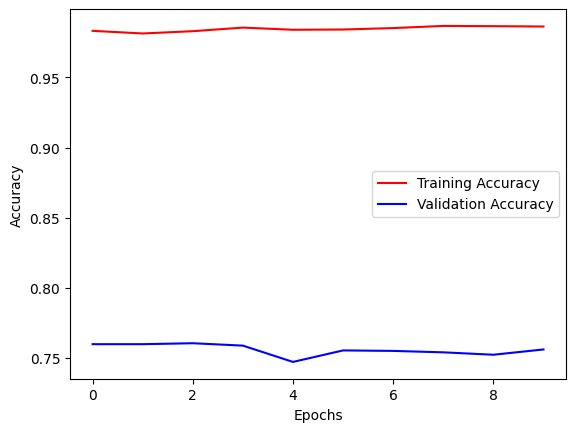

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLotting Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.figure()

In [ ]:
# Confusion Matrix
predictions = model.predict(testing_padded)

# Convert one-hot encoded labels back to class indices
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(testing_labels_encoded_onehot, axis=1)

# Generate confusion matrix
print(confusion_matrix(actual_labels, predicted_labels))
print(classification_report(actual_labels, predicted_labels))

92/92 [==============================] - 1s 10ms/step
[[1606  165   45]
 [ 231  343   52]
 [ 111  110  265]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1816
           1       0.56      0.55      0.55       626
           2       0.73      0.55      0.62       486

    accuracy                           0.76      2928
   macro avg       0.70      0.66      0.68      2928
weighted avg       0.75      0.76      0.75      2928



In [ ]:
tf.keras.backend.clear_session()

In [ ]:
## CNN Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, input_length=32, output_dim=16),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 conv1d (Conv1D)             (None, 28, 128)           10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 173539 (677.89 KB)
Trainable params: 173539 (677.89 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
## Train Model

history = model.fit(training_padded, training_labels_encoded_onehot, epochs=10,
                    validation_data=(testing_padded, testing_labels_encoded_onehot), verbose=0)

<Figure size 640x480 with 0 Axes>

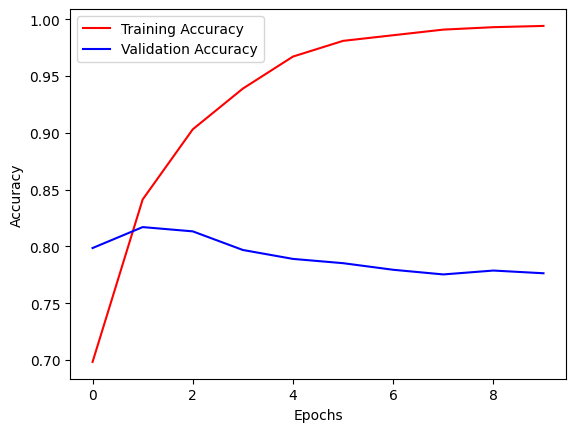

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLotting Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.figure()

In [ ]:
# Confusion Matrix
predictions = model.predict(testing_padded)

# Convert one-hot encoded labels back to class indices
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(testing_labels_encoded_onehot, axis=1)

# Generate confusion matrix
print(confusion_matrix(actual_labels, predicted_labels))
print(classification_report(actual_labels, predicted_labels))

92/92 [==============================] - 0s 4ms/step
[[1615  157   44]
 [ 201  358   67]
 [  88   98  300]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1816
           1       0.58      0.57      0.58       626
           2       0.73      0.62      0.67       486

    accuracy                           0.78      2928
   macro avg       0.72      0.69      0.71      2928
weighted avg       0.77      0.78      0.77      2928



## This project was completed in May 2024 with the help of Anthony Magro, a classmate of mine at Saint Joseph's University.